In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from nlinec import get_positive_data, get_all_types, get_results_dir, get_type, color_palette
from nlinec.data.preprocessing import get_granularity

## Parameters

In [3]:
granularities = ['Coarse', 'Medium', 'Fine']

In [4]:
# Specify the dataset to predict and a file to save the predictions to
DATASET = 'g_test.json'
SAVE_PREDICTIONS_TO = os.path.join(get_results_dir(), "predictions", "zero-shot", "test_predictions.csv")

# Specify the parameters for the analysis
MODEL = "roberta-large-mnli"

## Setup 

In [5]:
positive_data = get_positive_data(DATASET)
positive_data

Loading g_test.json: 8963it [00:00, 209941.23it/s]


,mention_span,full_type,sentence,label
0,Valley Federal Savings & Loan Association,"[/organization, /organization/company]",Valley Federal Savings & Loan Association sai...,2
1,Valley Federal,"[/organization, /organization/company]","Terms weren't disclosed, but Valley Federal ha...",2
2,Valley Federal,"[/organization, /organization/company]",Valley Federal said Friday that it is conside...,2
3,"Valley Federal , with assets of $ 3.3 billion ,","[/organization, /organization/company]","Valley Federal , with assets of $ 3.3 billion...",2
4,Imperial Corp. of America,"[/organization, /organization/company]",Valley Federal Savings & Loan Association said...,2
...,...,...,...,...
8958,"Fridays in general , which tend to be strong d...",[/other],Another study found that the 82 Fridays the 13...,2
8959,stocks,[/other],"But the date tends to be a plus, not a minus, ...",2
8960,the 1962 - 85 period,[/other],"But their study, which spanned the 1962 - 85 p...",2
8961,professors,[/person],"Robert Kolb and Ricardo Rodriguez, professors ...",2


In [6]:
gran_types = []
for i in [1, 2, 3]:
    all_types = get_all_types(granularity=i)
    all_types['granularity'] = all_types['full_type'].apply(lambda x: get_granularity(x))
    gran_types.append(all_types[all_types['granularity'] == i])

## Evaluate

In [7]:
# Get the predictions
predictions_df = pd.read_csv(SAVE_PREDICTIONS_TO, index_col=0)

# Combine the predictions with the original data based on the index
data_with_predictions = positive_data.join(predictions_df).explode('full_type')

# Add the granularity of the type
data_with_predictions['granularity'] = data_with_predictions['full_type'].apply(get_granularity)

# Reset the index
data_with_predictions.reset_index(drop=True, inplace=True)

In [8]:
# Compute the predicted type for each granularity
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the predicted type (i.e. the the name of the column with the maximum probability)
    data_with_predictions.loc[granularity_mask, 'predicted_type'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].idxmax(axis=1)

### Example

In [9]:
interesting_indices = [2979, 13391, 7809]

In [10]:
data_with_predictions.loc[interesting_indices]

,mention_span,full_type,sentence,label,/other,/other/body_part,/person/title,/person,/person/athlete,/other/art,...,/other/language/programming_language,/other/product/computer,/other/event/sports_event,/organization/stock_exchange,/location/structure/hotel,/location/transit/bridge,/location/transit/railway,/other/product/mobile_phone,granularity,predicted_type
2979,a new potato variety,/other/living_thing,The Weihai agricultural new high level technol...,2,0.868143,0.100906,0.838517,0.071172,0.604610,0.278404,...,0.017722,0.023682,0.063264,0.299262,0.084517,0.454595,0.049222,0.014734,2,/other/product
13391,professors,/person,"Robert Kolb and Ricardo Rodriguez, professors ...",2,0.577051,0.145499,0.849469,0.647637,0.386386,0.171833,...,0.083740,0.033256,0.017728,0.108233,0.019496,0.153253,0.220906,0.100980,1,/location
7809,a place,/location,"She transforms her `` Bronx of the emotions, a...",2,0.640957,0.141387,0.868219,0.475460,0.798393,0.424642,...,0.032412,0.005557,0.008966,0.028595,0.009027,0.363782,0.016873,0.024035,1,/location


In [11]:
probabilities = data_with_predictions.loc[interesting_indices, list(all_types['full_type'])]
# Sort the columns alphabetically
probabilities = probabilities.reindex(sorted(probabilities.columns), axis=1)

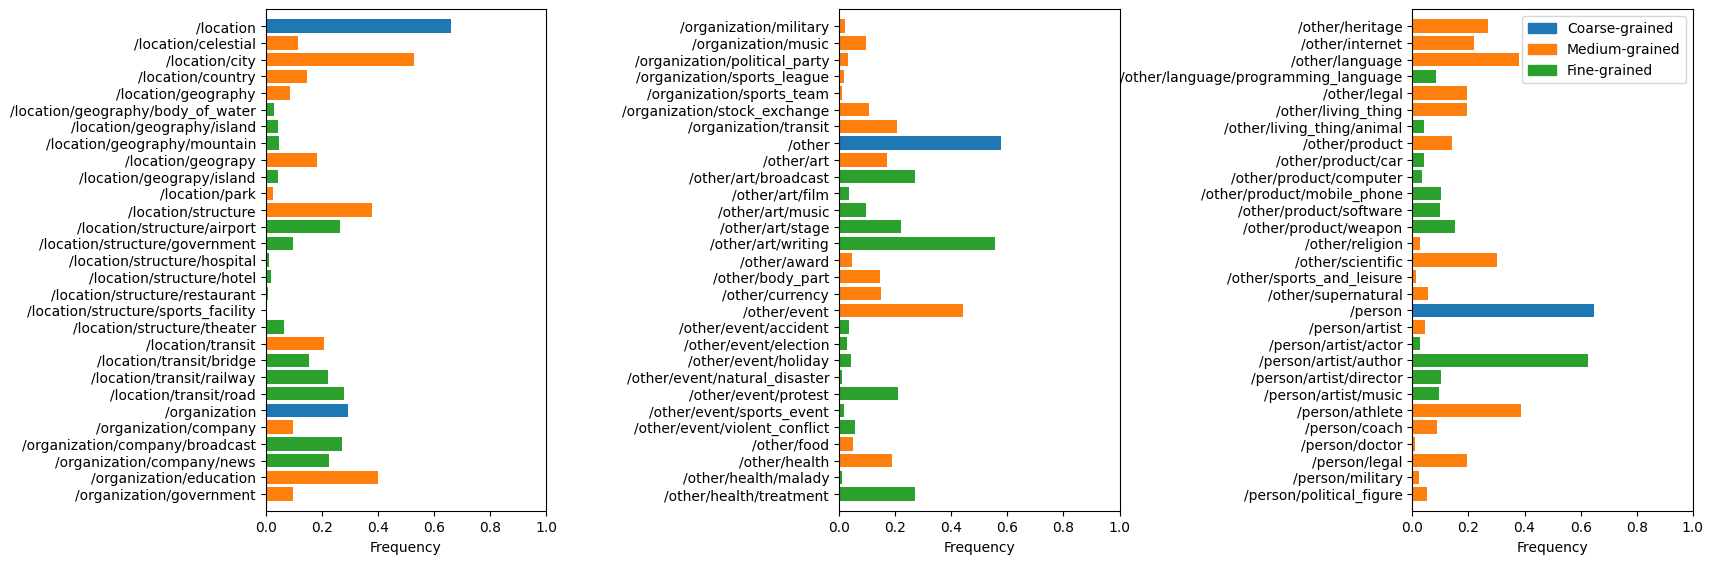

In [12]:
granularity_colors = ['tab:blue', 'tab:orange', 'tab:green']
granularity_labels = ['Coarse-grained', 'Medium-grained', 'Fine-grained']

# Split the plot over multiple columns
N_COLS = 3
type_per_col = probabilities.shape[1] // N_COLS

fig, axes = plt.subplots(1, N_COLS, figsize=(5 * N_COLS, 20 // N_COLS))
fig.tight_layout(w_pad=18)
fig.subplots_adjust(top=0.9)

for a, ax in enumerate(axes):
    start = a * type_per_col
    end = (a + 1) * type_per_col
    for i, (type, probability) in enumerate(probabilities.iloc[1, start:end].items()):
        ax.barh(len(probabilities.iloc[1, start:end]) - i, probability, color=granularity_colors[get_granularity(type) - 1])
    ax.set_yticks(np.arange(1, len(probabilities.iloc[1, start:end]) + 1))
    ax.set_yticklabels(probabilities.columns[start:end][::-1])
    ax.set_ylim(0, len(probabilities.iloc[1, start:end]) + 1)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Frequency')

# Add a legend
granularity_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in granularity_colors]
axes[-1].legend(granularity_handles, granularity_labels, loc='upper right');

In [13]:
data_with_predictions.loc[13391]

mention_span                                                          professors
full_type                                                                /person
sentence                       Robert Kolb and Ricardo Rodriguez, professors ...
label                                                                          2
/other                                                                  0.577051
                                                     ...                        
/location/transit/bridge                                                0.153253
/location/transit/railway                                               0.220906
/other/product/mobile_phone                                              0.10098
granularity                                                                    1
predicted_type                                                         /location
Name: 13391, Length: 95, dtype: object

### Accuracy

In [14]:
# Compute the overall accuracy for each granularity
accuracy = pd.DataFrame(columns=['granularity', 'accuracy'], index=[0, 1, 2])
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy
    # accuracy.append((data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']).mean())
    accuracy.loc[i - 1, 'granularity'] = i
    accuracy.loc[i - 1, 'accuracy'] = (data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']).mean()

    # Add a column that stores if the prediction was correct
    data_with_predictions.loc[granularity_mask, 'correct'] = data_with_predictions.loc[granularity_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask, 'full_type']

In [15]:
accuracy

,granularity,accuracy
0,1,0.460074
1,2,0.346492
2,3,0.441247


### Probability Bands

In [16]:
# Now compute the accuracy in prediction bands of 10% (i.e. 0-10%, 10-20%, etc.)
# First, compute the probability of the correct type
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Add a new column which stores the probability of the correct type
    data_with_predictions.loc[granularity_mask, 'predicted_type_probability'] = data_with_predictions.loc[granularity_mask, list(gran_types[i - 1]['full_type'])].max(axis=1)

In [17]:
# Compute the accuracy in each band
probability_bands = np.linspace(0, 1, 11)
band_accuracy_at_granularity = [pd.DataFrame(columns=['band', 'accuracy', 'support'], index=range(len(probability_bands) - 1)) for _ in range(3)]
for i in [1, 2, 3]:
    # Get the rows where the correct type has the correct granularity
    granularity_mask = data_with_predictions['granularity'] == i

    # Compute the accuracy in each band
    for j in range(len(probability_bands) - 1):
        # Get the rows where the probability of the correct type is in the current band
        band_mask = (data_with_predictions['predicted_type_probability'] >= probability_bands[j]) & (data_with_predictions['predicted_type_probability'] < probability_bands[j + 1])

        # Compute the accuracy
        band_accuracy_at_granularity[i - 1].loc[j, 'band'] = f"{probability_bands[j + 1]*100:.0f}"
        band_accuracy_at_granularity[i - 1].loc[j, 'accuracy'] = (data_with_predictions.loc[granularity_mask & band_mask, 'predicted_type'] == data_with_predictions.loc[granularity_mask & band_mask, 'full_type']).mean()
        band_accuracy_at_granularity[i - 1].loc[j, 'support'] = (data_with_predictions.loc[granularity_mask & band_mask].shape[0])

/tmp/ipykernel_12804/63456576.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(band_accuracy_at_granularity[i]['band'])


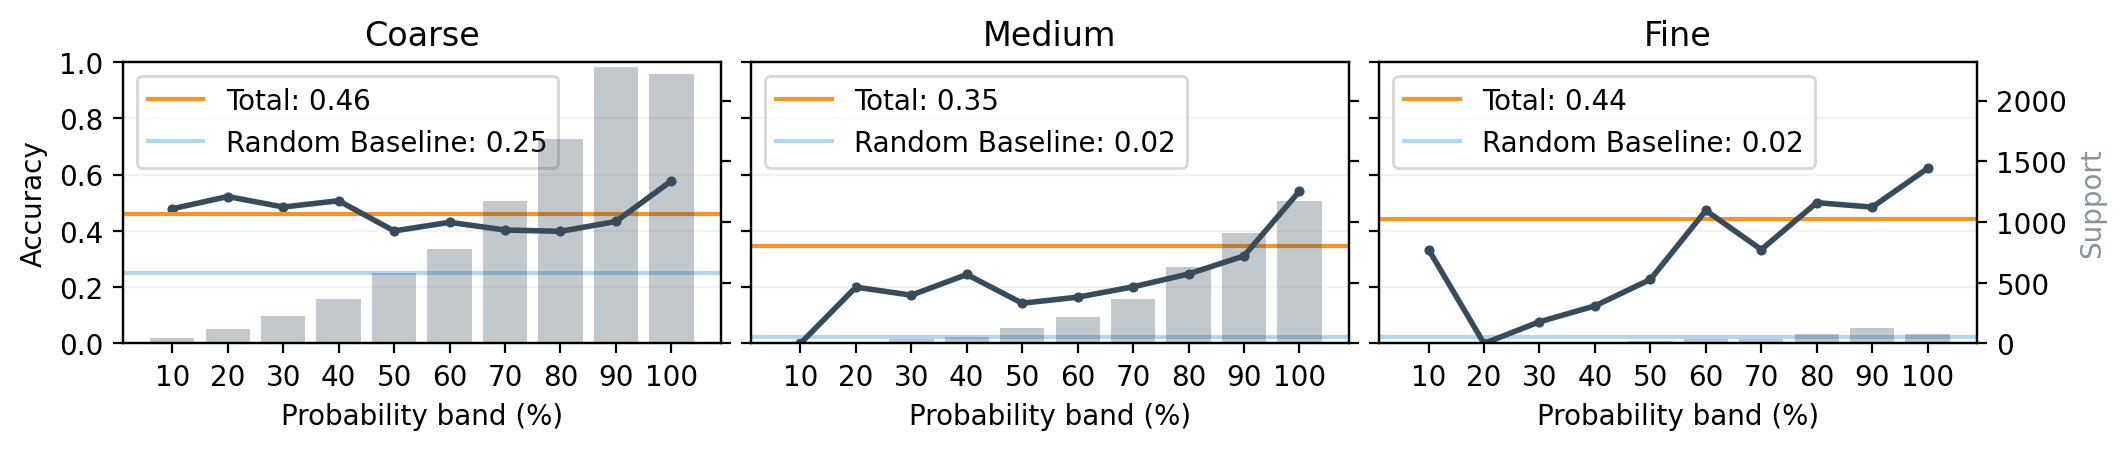

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2), dpi=200)
fig.tight_layout(w_pad=-2)
for i, ax in enumerate(axes):
    ax.plot(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['accuracy'], color=color_palette('medium'), linewidth=2)
    ax.scatter(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['accuracy'], color=color_palette('medium'), s=7)
    ax.set_title(granularities[i])
    ax.set_xlabel("Probability band (%)")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(band_accuracy_at_granularity[i]['band'])

    ax.axhline(accuracy.loc[i, 'accuracy'], color=color_palette('accent'), label=f'Total: {accuracy.loc[i, "accuracy"]:.2f}', zorder=1)
    ax.axhline(1 / gran_types[i].shape[0], color=color_palette('light'), label=f'Random Baseline: {1 / gran_types[i].shape[0]:.2f}', zorder=1)

    # Draw a bar for the support
    ax2 = ax.twinx()
    ax2.bar(band_accuracy_at_granularity[i]['band'], band_accuracy_at_granularity[i]['support'], color=color_palette('medium'), alpha=0.3)
    ax2.set_ylim(0, 1.02 * max([band_accuracy_at_granularity[i]['support'].max() for i in range(3)]))

    if i != 2:
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel("Support", color=color_palette('medium'), alpha=0.6)

    ax.grid(axis='y', color=color_palette('bright'))

    ax.legend(loc='upper left')

axes[0].set_ylabel("Accuracy")
axes[1].set_yticklabels([])
axes[2].set_yticklabels([]);

### Sibling & Hypernym Probability

In [20]:
# Get the full_type and predicted type at each granularity
for i in [1, 2, 3]:
    # Get the ground truth type at the current granularity
    data_with_predictions[f'type_{i}'] = data_with_predictions['full_type'].apply(lambda x: get_type(x, granularity=i))

    # Get the predicted type at the current granularity
    data_with_predictions[f'predicted_type_{i}'] = data_with_predictions['predicted_type'].apply(lambda x: get_type(x, granularity=i))

    # Get the probability of the predicted type at the current granularity
    data_with_predictions[f'predicted_type_{i}_probability'] = data_with_predictions.apply(lambda row: row.get(get_type(row['predicted_type'], include_path=True, granularity=i)), axis=1)

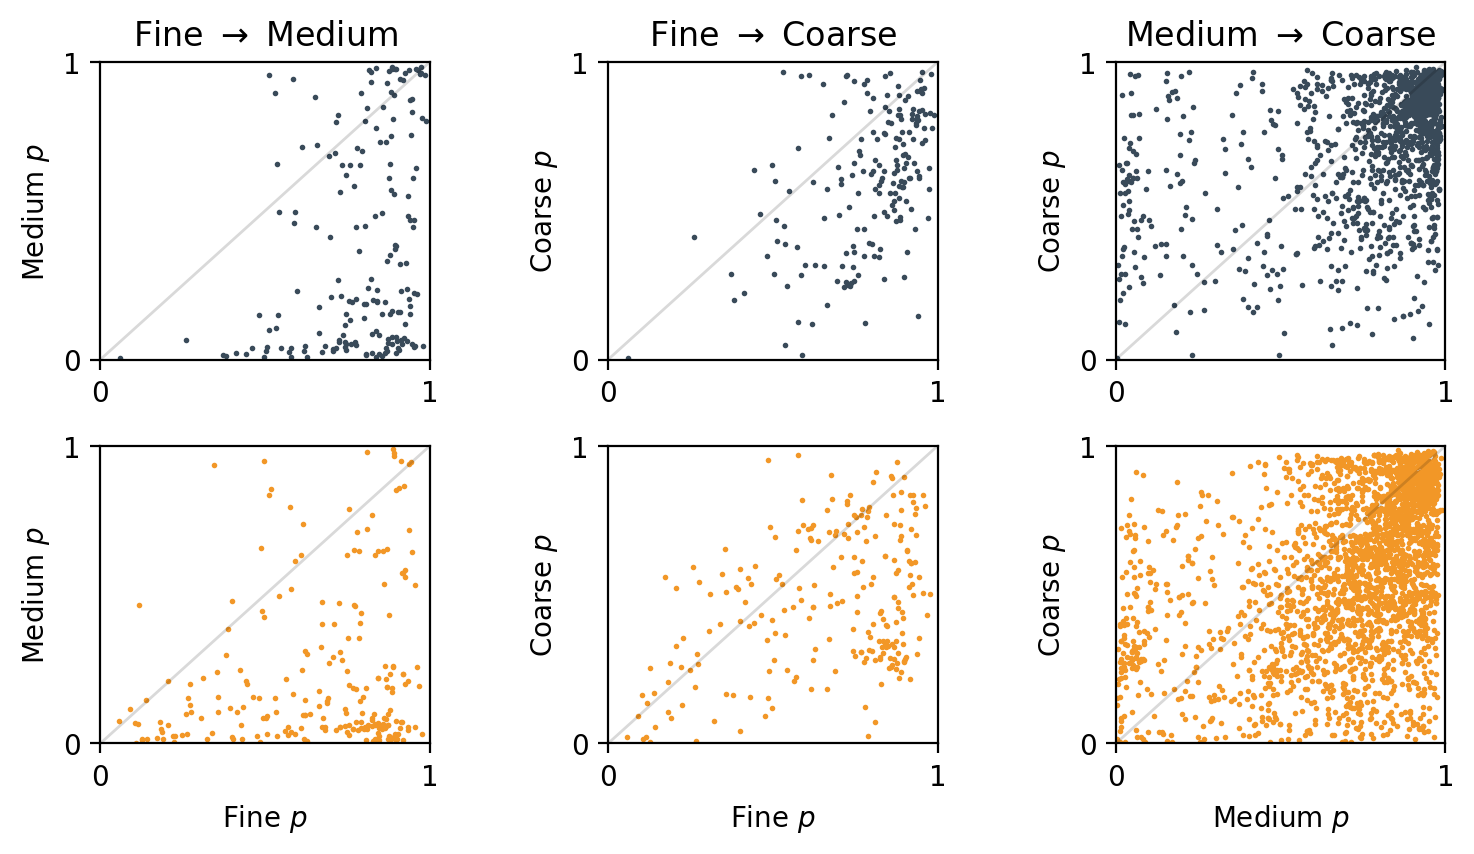

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(7.5, 4), dpi=200)
fig.tight_layout(w_pad=3, h_pad=1)
for i, (ax_row, color, mask) in enumerate(zip(axes, [color_palette('medium'), color_palette('accent')], [data_with_predictions['correct'].values, ~(data_with_predictions['correct'].astype(bool))])):
    for ax, (granularity_name, hypernym_granularity_name), (granularity, hypernym_granularity) in zip(ax_row, [('Fine', 'Medium'), ('Fine', 'Coarse'), ('Medium', 'Coarse')], [(3, 2), (3, 1), (2, 1)]):
        ax.scatter(data_with_predictions.loc[mask, f'predicted_type_{granularity}_probability'], data_with_predictions.loc[mask, f'predicted_type_{hypernym_granularity}_probability'], s=1, color=color)
        ax.plot([0, 1], [0, 1], color='k', linewidth=1, alpha=0.15)
        if i == 0:
            ax.set_title(f'{granularity_name} $\\rightarrow$ {hypernym_granularity_name}')
        if i == 1:
            ax.set_xlabel(f'{granularity_name} $p$')
        ax.set_ylabel(f'{hypernym_granularity_name} $p$')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])